In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl

from ncps.wirings import AutoNCP
from ncps.torch import LTC

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'data/parquet/est_hourly.parquet'

df = pd.read_parquet(path).reset_index()[["Datetime", "AEP"]].rename(
    columns={"Datetime": "datetime", "AEP": "value"}
)
df = df.set_index("datetime")
df.head()

,value
datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [3]:
#df = df[~df.value.isna()]
subsample = df.dropna()
sorted_idx = subsample.index.sort_values()
subsample = subsample.loc[sorted_idx]
subsample = subsample[subsample.index < "2006-01-01 00:00:00"]

In [4]:
# Factorize the timestamps
int_sequence, unique_timestamps = pd.factorize(subsample.index)

In [38]:
# Min-Max Normalization
tensor_min = subsample.value.min()
tensor_max = subsample.value.max()

subsample.value = (subsample.value - tensor_min) / (tensor_max - tensor_min)

In [39]:
year_shift = 365
week_shift = 7
x_true = subsample.value[year_shift*24+1:]
x_shifted_year = subsample.value
x_shifted_week = subsample.value[week_shift*24:]


In [41]:
x_ax = list(zip(x_true, x_shifted_week, x_shifted_year))

In [44]:
# Factorize the timestamps
int_sequence, unique_timestamps = pd.factorize(subsample.index)
data_x = torch.Tensor(x_ax)#.view((1, -1, 1))
data_y = torch.Tensor(subsample.value[:data_x.shape[0]]).view((-1, 1))
dataloader = data_utils.DataLoader(
    data_utils.TensorDataset(data_x, data_y), batch_size=7, shuffle=True, num_workers=1
)

C:\Users\stase\AppData\Local\Temp\ipykernel_23796\1852603592.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_y = torch.Tensor(subsample.value[:data_x.shape[0]]).view((-1, 1))


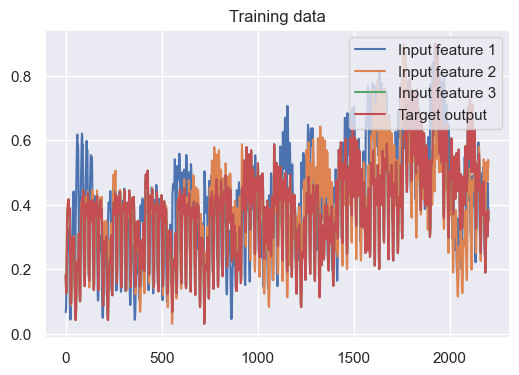

In [48]:
# Let's visualize the training data
sns.set_theme()
plt.figure(figsize=(6, 4))
plt.plot(data_x[:, 0], label="Input feature 1")
plt.plot(data_x[:, 1], label="Input feature 2")
plt.plot(data_x[:, 2], label="Input feature 3")
plt.plot(data_y[:, 0], label="Target output")
#plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [85]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    # TODO: Iterieren Tag"
    # Cycle 0"
    # VITALI: Lücken schließen, Wochentage, Feiertage"
    # Alle Indizes müssen mit 24 multipliziert werden, da wir stündliche Auflösung haben"
    # Iteration 0: y_(-1) , y_(-7) , y_(-365) -> y_hat(0) V y_(0)"
    # Iteration 1: y_hat(0) , y_(-6) , y_(-364) -> y_hat(1) V y_(1)"
    # Iteration 2: y_hat(1) , y_(-5) , y_(-363) -> y_hat(2) V y_(2)"
    # ..."
    # Iteration 6: y_hat(5) , y_(-1) , y_(-359) -> y_hat(6) V y_(6)"
    # Cycle 1"
    # Iteration 7: y_(6) , y_(0) , y_(-358) -> y_hat(7) V y_(7)
    # ...
    # Iteration 12: y_hat(5) , y_(6) , y_(-352) -> y_hat(12) V y_(12)
    # Modell speichern?"
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        print("\n", "Batch idx: ", batch_idx)
        x, y = batch
        x = x.view((1, -1, 3))
        y = y.view((1, -1, 1))

        loss = 0.0

        for idx in range(x.shape[1]):
            # get current row
            x_curr = torch.index_select(x, 1, torch.tensor([idx]))
            y_curr = torch.index_select(y, 1, torch.tensor([idx]))
            y_hat, _ = self.model.forward(x_curr)

            y_hat = y_hat.view_as(y_curr)
            loss += nn.MSELoss()(y_hat, y_curr)

            print(loss)

            try:
                # replace y true with prediction
                x[0, idx + 1, 0] = y_hat.item()
            except IndexError:
                # last element of the batch reached
                pass

        self.log("train_loss", loss/y.shape[1], prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view((1, -1, 3))
        y = y.view((1, -1, 1))
        
        loss = 0.0

        for idx in range(x.shape[1]):
            # get current row
            x_curr = torch.index_select(x, 1, torch.tensor([idx]))
            y_curr = torch.index_select(y, 1, torch.tensor([idx]))
            y_hat, _ = self.model.forward(x_curr)
            y_hat = y_hat.view_as(y_curr)

            loss += nn.MSELoss()(y_hat, y_curr)

            try:
                # replace y true with prediction
                x[0, idx + 1, 0] = y_hat.item()
            except IndexError:
                # last element of the batch reached
                pass

        self.log("val_loss", loss/y.shape[1], prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

In [86]:
out_features = 1
in_features = 3

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True, use_swish_activation=False)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=1,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


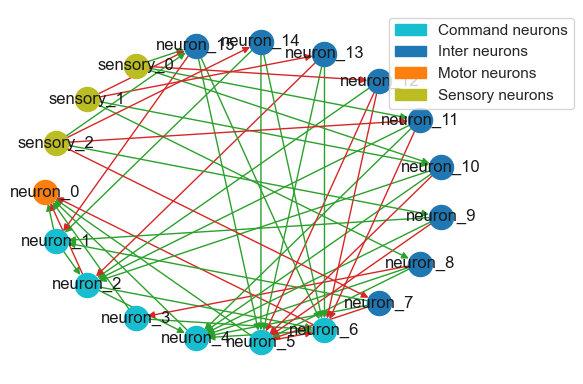

In [57]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

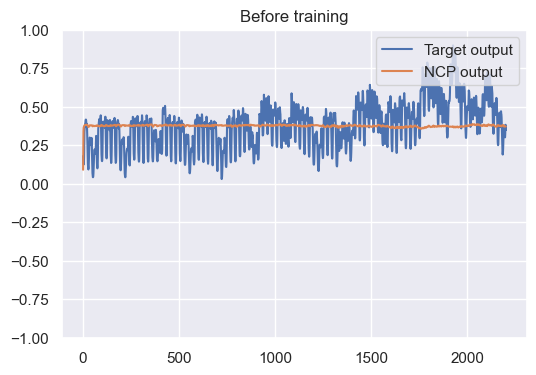

In [58]:
# Let's visualize how LTC initialy performs before the training
sns.set_theme()
with torch.no_grad():
    prediction = ltc_model(data_x.view(1, -1, 3))[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [87]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 1.6 K  | train
---------------------------------------
1.3 K     Trainable params
304       Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 0/315 [00:00<?, ?it/s] 
 Batch idx:  0
tensor(0.1745, grad_fn=<AddBackward0>)
tensor(0.2412, grad_fn=<AddBackward0>)
tensor(0.2414, grad_fn=<AddBackward0>)
tensor(0.2414, grad_fn=<AddBackward0>)
tensor(0.2419, grad_fn=<AddBackward0>)
tensor(0.2536, grad_fn=<AddBackward0>)
tensor(0.3421, grad_fn=<AddBackward0>)
Epoch 0:   0%|          | 1/315 [00:01<10:06,  0.52it/s, v_num=13, train_loss=0.0489]
 Batch idx:  1
tensor(0.0345, grad_fn=<AddBackward0>)
tensor(0.0504, grad_fn=<AddBackward0>)
tensor(0.1164, grad_fn=<AddBackward0>)
tensor(0.1558, grad_fn=<AddBackward0>)
tensor(0.1565, grad_fn=<AddBackward0>)
tensor(0.1934, grad_fn=<AddBackward0>)
tensor(0.2184, grad_fn=<AddBackward0>)
Epoch 0:   1%|          | 2/315 [00:01<05:04,  1.03it/s, v_num=13, train_loss=0.0312]
 Batch idx:  2
tensor(0.0293, grad_fn=<AddBackward0>)
tensor(0.0980, grad_fn=<AddBackward0>)
tensor(0.1301, grad_fn=<AddBackward0>)
tensor(0.1303, grad_fn=<AddBackward0>)
tensor(0.1352, grad_fn=<AddBack

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 315/315 [00:06<00:00, 45.82it/s, v_num=13, train_loss=0.000131]


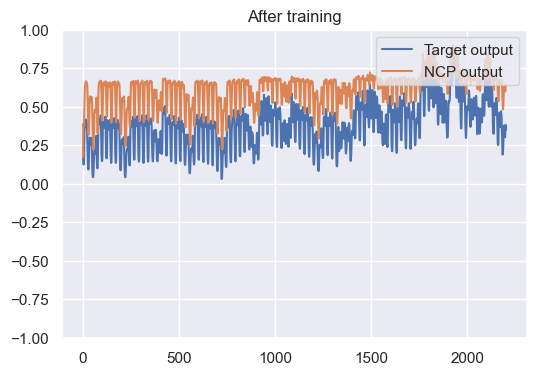

In [90]:
# How does the trained model now fit to the sinusoidal function?
sns.set_theme()
with torch.no_grad():
    prediction = ltc_model(data_x.view(1, -1, 3))[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

In [99]:
# Min-Max De-Normalization
denormalized_tensor = data_y[:, 0] * (tensor_max - tensor_min) + tensor_min
denormalized_preds = prediction[0, :, 0] * (tensor_max - tensor_min) + tensor_min

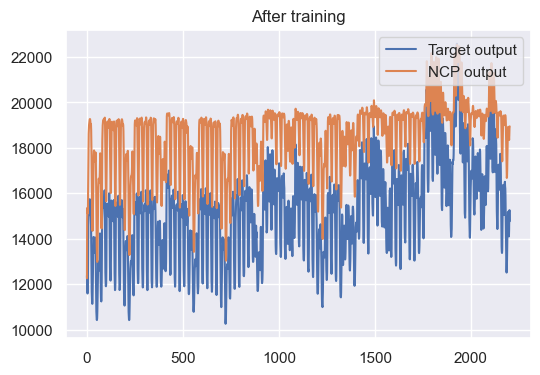

In [113]:
# How does the trained model now fit to the sinusoidal function?
sns.set_theme()
plt.figure(figsize=(6, 4))
plt.plot(denormalized_tensor, label="Target output")
plt.plot(denormalized_preds, label="NCP output")

plt.title("After training")
plt.legend(loc="upper right")
plt.show()